In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Not connected to a GPU


#DCGAN
Code from the paper "Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks". 

#Dataset
I'll be using the CelebA dataset as the ground truth for the probability distribution. The GAN will be trained to generate faces.

In [2]:
!git clone https://github.com/tkarras/progressive_growing_of_gans.git

fatal: destination path 'progressive_growing_of_gans' already exists and is not an empty directory.


In [3]:
!gdown --id 12rFbtWMg1NUCW4JKm_dwBpGdb6e-BuHg

Downloading...
From: https://drive.google.com/uc?id=12rFbtWMg1NUCW4JKm_dwBpGdb6e-BuHg
To: /content/CelebA.zip
100% 1.44G/1.44G [00:16<00:00, 88.4MB/s]


In [4]:
!unzip "/content/CelebA.zip" -d "/content/CelebA"

Archive:  /content/CelebA.zip
replace /content/CelebA/img_align_celeba/000001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [5]:
!pip install tensorflow
!pip install tensorflow_datasets

In [6]:
!sudo du CelebA
!sudo ls CelebA/img_align_celeba | wc -l

1743696	CelebA/img_align_celeba
1743700	CelebA
202599


In [31]:
# Define Generator and Discriminator

import tensorflow as tf

FINAL_DIM = 16
IMAGE_RES = 64
NOISE_DIM = 100

def Generator():
      
  def add_g_layer(x, filters):
    """
    Generator layers are made up of a fractionally-strided convolution 
    ("deconvolution"), BatchNorm, and ReLU activation. 
    """
    x = tf.keras.layers.Conv2DTranspose(filters, kernel_size=(5, 5), 
                                        strides=(2, 2), padding='same', 
                                        activation=None)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    return x

  def output_g_layer(x):
    # Final fractionally-strided convolution ("deconvolution") into image space
    x = tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=(5, 5), 
                                        strides=(2, 2), padding='same', 
                                        activation=None)(x)
    x = tf.math.tanh(x)
    return x

  # Define input noise vector shape
  noise_input = tf.keras.layers.Input(shape=(NOISE_DIM))

  # Initial projection into 4x4 feature maps
  x = tf.keras.layers.Dense(4 * 4 * (FINAL_DIM * 8), 
                            activation=None)(noise_input)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Reshape((4, 4, (FINAL_DIM * 8)))(x)

  # Generator fractionally-strided convolutional layers
  x = add_g_layer(x, filters=FINAL_DIM * 4)
  x = add_g_layer(x, filters=FINAL_DIM * 2)
  x = add_g_layer(x, filters=FINAL_DIM)

  # Final convolution (convert feature maps into image)
  x = output_g_layer(x)

  # Model definition
  model = tf.keras.Model(inputs=noise_input, outputs=x, name='DCGAN_Generator')

  print(model.summary())

  return model


def Discriminator():

  """
  The Discriminator, for the most part, mirrors, the Generator. Key differences
  are 1) LeakyReLU(0.2) instead of ReLU, and 2) Output FC layer(1) with sigmoid
  activation.
  """

  def add_d_layer(x, filters):
    """
    Discriminator layers are made up of a strided convolutional layer 
    (downsampling without pooling), BatchNorm, and LeakyReLU (leak=0.2)
    """
    x = tf.keras.layers.Conv2D(filters, kernel_size=(5, 5), strides=(2, 2), 
                               padding='same', activation=None)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    return x

  def output_d_layer(x):
    """
    Final layer in Discriminator. Single neuron with sigmoid activation for
    classification of image as fake or real. 
    """
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.math.sigmoid(x)
    return x

  """Start: Image of dimensions (64, 64, 3). End: Fake/real classification value 
  ranging [0, 1]"""

  image_input = tf.keras.layers.Input(shape=(IMAGE_RES, IMAGE_RES, 3))

  # Discriminator's strided convolutions
  x = add_d_layer(image_input, filters=FINAL_DIM)
  x = add_d_layer(x, filters=FINAL_DIM * 2)
  x = add_d_layer(x, filters=FINAL_DIM * 4)
  x = add_d_layer(x, filters=FINAL_DIM * 8)

  # Discriminator's output layer
  x = output_d_layer(x)

  model = tf.keras.Model(inputs=image_input, outputs=x, 
                         name='DCGAN_Discriminator')

  print(model.summary())

  return model

g = Generator()
d = Discriminator()


Model: "DCGAN_Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_6 (Dense)             (None, 2048)              206848    
                                                                 
 batch_normalization_27 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 reshape_3 (Reshape)         (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose_12 (Conv2D  (None, 8, 8, 64)         204864    
 Transpose)                                                      
                                                                 
 batch_normalization_28 (Bat  (None, 8, 8, 64)     

In [8]:
!pip install opencv-python

(218, 178, 3)


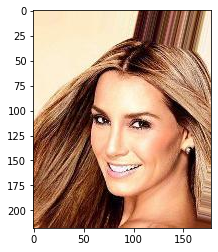

In [94]:
# Test image read

import cv2
import matplotlib.pyplot as plt

# Read in image as ndarray
img = cv2.imread('CelebA/img_align_celeba/000001.jpg')
# BGR -> RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Starting images are 178px resolution
print(img.shape)

# print(img)
plt.imshow(img)

(178, 178, 3)


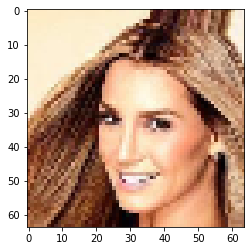

In [113]:

original_img = cv2.imread('CelebA/img_align_celeba/000001.jpg')

# Crop out top and bottom evenly to create a square image
crop_margin = int((original_img.shape[0] - original_img.shape[1]) / 2)
original_img = original_img[crop_margin:(original_img.shape[0] - crop_margin)]

print(original_img.shape)

# Resize to 64x64
img = cv2.resize(original_img, (64, 64))

# BGR -> RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)

In [10]:
!pip install tqdm

In [11]:
# I'm only going to take a subset of the data for now for training

SUBSET_AMOUNT = 10000

In [124]:
# Read images as dataset

import os
import numpy as np
from tqdm import tqdm

ds_list = []

directory = r'/content/CelebA/img_align_celeba'
for filename in tqdm(os.listdir(directory)[:SUBSET_AMOUNT]):

  if filename.endswith('.jpg'):

    # Read in image as ndarray
    img = cv2.imread('CelebA/img_align_celeba/' + filename)

    # Crop out top and bottom evenly to create a square image
    crop_margin = int((img.shape[0] - img.shape[1]) / 2)
    img = img[crop_margin:(img.shape[0] - crop_margin)]

    # Resize to 64x64
    img = cv2.resize(img, (64, 64))

    # BGR -> RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # ds = np.append(ds, img)
    ds_list.append(img)

ds = np.array(ds_list)

100%|██████████| 10000/10000 [00:23<00:00, 424.08it/s]


In [125]:
# Move all pixel values into the range [-1, 1] (the range of tanh)

ds = (ds / (255.0/2)) - 1.0

In [126]:
ds[0]

array([[[0.70196078, 0.70980392, 0.74901961],
        [0.91372549, 0.92941176, 0.95294118],
        [0.38039216, 0.38823529, 0.40392157],
        ...,
        [0.99215686, 0.99215686, 0.92941176],
        [0.89019608, 0.8745098 , 0.64705882],
        [0.98431373, 0.91372549, 0.65490196]],

       [[0.65490196, 0.6627451 , 0.70196078],
        [0.96078431, 0.96862745, 0.98431373],
        [0.43529412, 0.43529412, 0.45882353],
        ...,
        [0.98431373, 0.98431373, 0.92941176],
        [0.89803922, 0.88235294, 0.64705882],
        [0.97647059, 0.90588235, 0.64705882]],

       [[0.59215686, 0.6       , 0.63921569],
        [0.98431373, 0.99215686, 1.        ],
        [0.45882353, 0.46666667, 0.48235294],
        ...,
        [0.99215686, 0.99215686, 0.9372549 ],
        [0.89803922, 0.88235294, 0.65490196],
        [0.96862745, 0.89803922, 0.63921569]],

       ...,

       [[0.92156863, 0.85098039, 0.59215686],
        [0.92156863, 0.85098039, 0.59215686],
        [0.92156863, 0

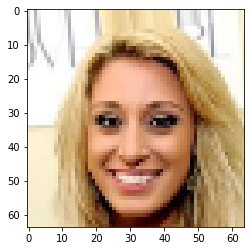

In [137]:
_ = (ds[0]+1.0)/2

plt.imshow(_)

#Training Loop

In [74]:
# Test noise input for Generator

def get_noise_samples(n_samples):
  return(np.random.rand(n_samples, 100))

rand_noise_vec = get_noise_samples(1)
rand_noise_vec

array([[0.30065279, 0.12152461, 0.64543608, 0.54254932, 0.03784098,
        0.01205984, 0.03739374, 0.7951436 , 0.88821695, 0.53785778,
        0.81668492, 0.39029359, 0.52594124, 0.6031653 , 0.14330293,
        0.91191488, 0.7769344 , 0.12386932, 0.13664444, 0.82471774,
        0.08200672, 0.25629015, 0.2307162 , 0.70814597, 0.01497967,
        0.1786488 , 0.86275253, 0.52653676, 0.55126301, 0.88298901,
        0.74699138, 0.76734459, 0.91195958, 0.75232358, 0.84489314,
        0.32043437, 0.0958233 , 0.25439597, 0.97164876, 0.74286545,
        0.75064683, 0.68370858, 0.76845454, 0.68073646, 0.93385385,
        0.99784523, 0.56997592, 0.877123  , 0.51639029, 0.35822363,
        0.15348785, 0.23691969, 0.57831662, 0.24065003, 0.45620315,
        0.64425295, 0.85928247, 0.28270708, 0.04502082, 0.75016609,
        0.76254172, 0.47863489, 0.4034047 , 0.19877797, 0.21749457,
        0.02959771, 0.02852255, 0.83607683, 0.42768574, 0.93894998,
        0.42727499, 0.741335  , 0.93702566, 0.61

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


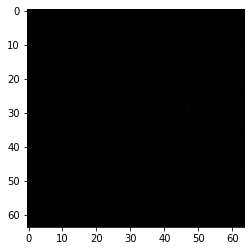

In [59]:
# Feed noise into G and see what we get

test_img = g(rand_noise_vec)

# print(test_img)

for img in test_img:
  plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


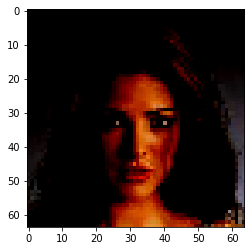

In [155]:
# Sampling random images from the dataset

def get_image_samples(n_samples):
  return(ds[np.random.randint(ds.shape[0], size=n_samples)])

plt.imshow(get_image_samples(1)[0])

In [138]:
# Training loop

EPOCHS = 1
D_STEPS = 1
G_STEPS = 1
BATCH_SIZE = 2

for i in range(EPOCHS):
  for j in range(D_STEPS):

    # Sample m noise samples
    noise_samples = get_noise_samples(BATCH_SIZE)

    # Get Generator examples from the noise
    g_examples = g(noise_samples)

    # Get real examples from dataset
    data_examples = get_image_samples(BATCH_SIZE)

    # Train Discriminator to distinguish between the two
    

  # for j in range(G_STEPS):

g_examples


<tf.Tensor: shape=(2, 64, 64, 3), dtype=float32, numpy=
array([[[[ 2.1376081e-05, -9.8766483e-05,  1.3394154e-05],
         [-5.9024343e-04,  3.5856276e-05,  1.2529304e-04],
         [ 3.7692062e-04,  6.7197092e-05,  1.8713798e-04],
         ...,
         [-1.3514768e-03,  8.3588180e-04, -7.5857301e-04],
         [ 1.6974477e-03,  6.7325187e-04,  4.4426290e-04],
         [-1.4080975e-03,  2.5438279e-04, -5.3215964e-04]],

        [[-3.8821262e-04,  4.1405168e-05,  5.0562376e-04],
         [ 1.3552062e-04, -8.5710417e-05, -4.0054761e-04],
         [ 5.0760468e-04, -1.0788026e-03,  5.4486759e-04],
         ...,
         [ 4.7877227e-04, -2.9732690e-03, -1.3404941e-03],
         [-2.1526248e-03,  3.4121599e-04, -5.3409947e-04],
         [-8.8751782e-04, -1.4672665e-03,  1.5557008e-03]],

        [[ 4.7964134e-04, -1.2843033e-04,  2.3532171e-04],
         [-5.6198164e-04,  5.9305987e-04, -4.5760476e-04],
         [ 1.3829388e-03,  4.8087249e-04,  1.0963618e-04],
         ...,
         [-1.

In [14]:
# Prepare data

real_ds = tf.keras.utils.image_dataset_from_directory('/content/CelebA/img_align_celeba/', 
                                                      validation_split=0.1, 
                                                      subset='training', seed=1)


Found 0 files belonging to 0 classes.
Using 0 files for training.


ValueError: ignored

In [ ]:
# Load dataset

import tensorflow_datasets as tfds

ds = tfds.load('celeb_a', shuffle_files=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

KeyError: ignored